# LSTM básico para etiquetado de secuencias

En este tutorial vamos a explorar la creación de un etiquetador con LSTMs. Vamos a procesar una frase con una etiquetas que llamamos "partes del habla" (Part of Speech), lo cuál no es nada mas que etiquetas con funciones gramaticales de cada palabra. 

Para ello vamos a usar la biblioteca keras, que en tensorflow ya es parte de esta. 

In [17]:
import tensorflow.keras as keras

### Preparar los datos

Ahora vamos a importar la base de datos con la que vemos a trabajar. Para ello usamos la biblioteca NLTK.

In [18]:
import nltk
#nltk.download("treebank")
#nltk.download("universal_tagset")

Ahora que ya tenemos instalados los datos vamos a cargar los datos a nuestro programa. Para poder ver los datos y entender su funcionamiento imprimiremos los mismos.

In [19]:
from nltk.corpus import treebank

sentences = treebank.tagged_sents(tagset="universal")
print(sentences[0])

[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')]


Ahora vamos a separar las palabras de los tags.

In [20]:
sentences_data = list()
tags_data = list()

# Separando tags de palabras
for sentence in sentences:
    s, t = zip(*sentence)
    sentences_data.append(s)
    tags_data.append(t)
    


Para separar los datos vamos a usar la biblioteca sklearn.  Lo vamos a hacer en tres partes. Uno para entrenar el modelo, otro para ajustar nuestros hiperparámetros y un último para probar nuestro modelo.Esta nos permite realizar la operación de manera automática.

In [21]:
from sklearn.model_selection import train_test_split

# Dividir los datos en tres conjuntos: train, dev y test

train_sent, test_sent, train_tags, test_tags = train_test_split(sentences_data, tags_data, test_size=0.2)
train_sent, dev_sent, train_tags, dev_tags = train_test_split(train_sent, train_tags, test_size=0.1)


# Hacer una lista de todos los tags y de todas las palabras vistas en el conjunto de entrenamiento

uniq_tags = list()
uniq_words = list()

for sent,tags in zip(train_sent, train_tags):
    for word, tag in zip(sent, tags):
        uniq_tags.append(tag)
        uniq_words.append(word)

uniq_tags = list(set(uniq_tags))
uniq_words = list(set(uniq_words))
    


Una vez que tenemos el dataset partido debidamente vamos a comprobar que sean del tamaño deseado y que contengan lo que esperamos.

In [22]:
print("Train len:", len(train_sent), "Dev len", len(dev_sent), "Test len", len(test_sent))
print(train_sent[0])
print(train_tags[0])

Train len: 2817 Dev len 314 Test len 783
('Stephen', 'Salmore', ',', 'a', 'political', 'scientist', 'at', 'New', 'Jersey', "'s", 'Eagleton', 'Institute', ',', 'says', '0', 'it', "'s", 'another', 'example', 'of', 'an', 'ad', 'that', '*T*-1', "'s", 'true', 'but', 'not', 'fully', 'accurate', '.')
('NOUN', 'NOUN', '.', 'DET', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'PRT', 'NOUN', 'NOUN', '.', 'VERB', 'X', 'PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'DET', 'X', 'VERB', 'ADJ', 'CONJ', 'ADV', 'ADV', 'ADJ', '.')


Una vez teniendo separados nuestros datasets, es tiempo de convertir los en números enteros, lo cuál nos va a permitir trabajar con ellos en una red neronal. 

In [23]:

word_to_indx = {"PAD":0,"OOV":1, "BOS":2, "EOS":3}
indx_to_word = {0:"PAD",1:"OOV", 2:"BOS", 3:"EOS"}


tag_to_indx = {"PAD":0, "OOV":1, "BOS":2, "EOS":3}
indx_to_tag = {0:"PAD", 1:"OOV", 2:"BOS", 3:"EOS"}

for line in train_sent:
    for word in line:
        if not word in word_to_indx.keys():
            word_to_indx[word] = len(word_to_indx)
            indx_to_word[len(word_to_indx)-1] = word
    
for line in train_tags:
    for tag in line:
        if not tag in tag_to_indx.keys():
            tag_to_indx[tag] = len(tag_to_indx)
            indx_to_tag[len(tag_to_indx)-1] = tag

print(tag_to_indx)
print(indx_to_tag)

{'PAD': 0, 'OOV': 1, 'BOS': 2, 'EOS': 3, 'NOUN': 4, '.': 5, 'DET': 6, 'ADJ': 7, 'ADP': 8, 'PRT': 9, 'VERB': 10, 'X': 11, 'PRON': 12, 'CONJ': 13, 'ADV': 14, 'NUM': 15}
{0: 'PAD', 1: 'OOV', 2: 'BOS', 3: 'EOS', 4: 'NOUN', 5: '.', 6: 'DET', 7: 'ADJ', 8: 'ADP', 9: 'PRT', 10: 'VERB', 11: 'X', 12: 'PRON', 13: 'CONJ', 14: 'ADV', 15: 'NUM'}


Es hora de convertir todas las frases en valores enteros. Esto lo realizaremos con nuestros índices que creamos arriba.

In [24]:
def sent_to_int(sent):
    int_sent = list()
    for word in sent:
        if word in word_to_indx.keys():
            int_sent.append(word_to_indx[word])
        else:
            int_sent.append(word_to_indx["OOV"])
    return int_sent

def tag_to_int(sent):
    int_sent = list()
    for tag in sent:
        if tag in tag_to_indx.keys():
            int_sent.append(tag_to_indx[tag])
        else:
            int_sent.append(tag_to_indx["OOV"])
    return int_sent

train_X, dev_X, train_Y, dev_Y, test_X, test_Y = list(), list(), list(), list(), list(), list()

for lineX, lineY in zip(train_sent, train_tags):
    train_X.append(sent_to_int(lineX))
    train_Y.append(tag_to_int(lineY))

for lineX, lineY in zip(dev_sent, dev_tags):
    dev_X.append(sent_to_int(lineX))
    dev_Y.append(tag_to_int(lineY))

for lineX, lineY in zip(test_sent, test_tags):
    test_X.append(sent_to_int(lineX))
    test_Y.append(tag_to_int(lineY))

Para poder trabajar con datos secuenciales desde keras, será necesario que todas las frases tengan el mismo tamaño. Para ello vamos a llenar los espacios vacíos de cada frase con un símbolo de PAD. Este valor es 0, y está acorde a lo que definimos anteriormente.

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LENGTH = len(max(train_X, key=len))
train_X = pad_sequences(maxlen=MAX_LENGTH, sequences=train_X, padding="post")
train_Y = pad_sequences(maxlen=MAX_LENGTH, sequences=train_Y, padding="post")
dev_X = pad_sequences(maxlen=MAX_LENGTH, sequences=dev_X, padding="post")
dev_Y = pad_sequences(maxlen=MAX_LENGTH, sequences=dev_Y, padding="post")
test_X = pad_sequences(maxlen=MAX_LENGTH, sequences=test_X, padding="post")
test_Y = pad_sequences(maxlen=MAX_LENGTH, sequences=test_Y, padding="post")

print(len(train_Y))
print(len(train_X[0]))
print(train_X[0])

2817
128
[ 4  5  6  7  8  9 10 11 12 13 14 15  6 16 17 18 13 19 20 21 22 23 24 25
 13 26 27 28 29 30 31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]


Las salidas de cada etiqueta es categórica. Por lo que debemos de ajustar los datos de todas las Y a valores categógicos.

In [26]:
from tensorflow.keras.utils import to_categorical

train_cat_Y = [to_categorical(i, num_classes=len(tag_to_indx)) for i in train_Y]
dev_cat_Y = [to_categorical(i, num_classes=len(tag_to_indx)) for i in dev_Y]
test_cat_Y = [to_categorical(i, num_classes=len(tag_to_indx)) for i in test_Y]

print(len(tag_to_indx))
print(len(train_cat_Y))
print(len(train_cat_Y[0]))
print(len(train_cat_Y[0][0]))
print(train_cat_Y[0])

16
2817
128
16
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


### Definir el modelo LSTM

Es hora de definir el modelo y generar los embeddings para que nuestros datos puedan ser usados en la red neuronal.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional


input = keras.Input(shape=(MAX_LENGTH,))
model = Embedding(input_dim=len(word_to_indx), output_dim=50, input_length=MAX_LENGTH)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(len(tag_to_indx), activation="softmax"))(model)  # softmax output layer

In [28]:
model = Model(input, out)

In [30]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [32]:
import numpy as np
print(len(train_X[0]), len(train_X))
print(len(train_cat_Y[0]), len(train_cat_Y))

history = model.fit(train_X, np.array(train_cat_Y), batch_size=32, epochs=5, validation_data=[dev_X, np.array(dev_cat_Y)], verbose=1)

128 2817
128 2817
Train on 2817 samples, validate on 314 samples
Epoch 1/5
2817/2817 [==============================] - 127s 45ms/sample - loss: 0.6060 - acc: 0.8329 - val_loss: 0.4340 - val_acc: 0.8594
Epoch 2/5
2817/2817 [==============================] - 131s 47ms/sample - loss: 0.3837 - acc: 0.8769 - val_loss: 0.2798 - val_acc: 0.9214
Epoch 3/5
2817/2817 [==============================] - 138s 49ms/sample - loss: 0.1897 - acc: 0.9466 - val_loss: 0.1225 - val_acc: 0.9624
Epoch 4/5
2817/2817 [==============================] - 152s 54ms/sample - loss: 0.0832 - acc: 0.9759 - val_loss: 0.0684 - val_acc: 0.9791
Epoch 5/5
2817/2817 [==============================] - 141s 50ms/sample - loss: 0.0443 - acc: 0.9879 - val_loss: 0.0456 - val_acc: 0.9873


# Resultados

Veamos como se comportó nuestro modelo a travéz de las épocas de entrenamiento. Vemos tanto el accuracy sobre el conjunto de entrenamiento, así como también sobre el conjunto de validación.

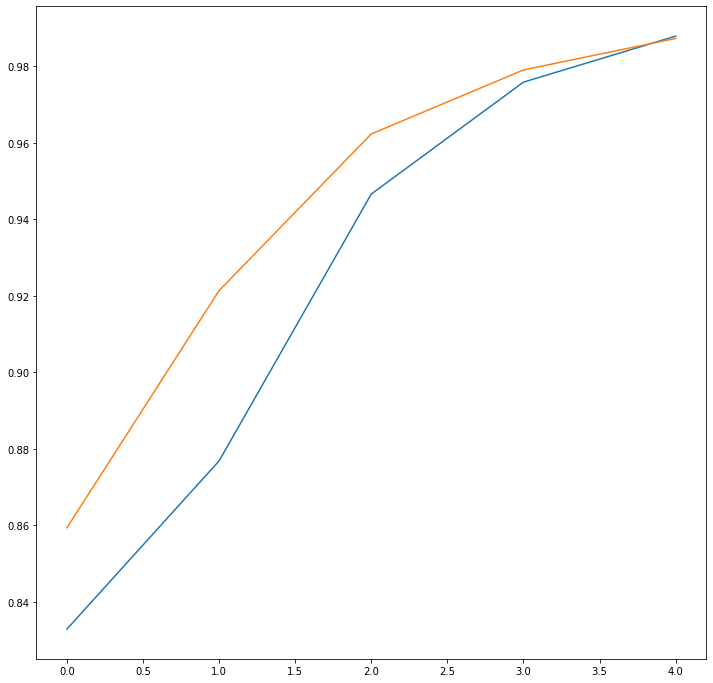

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

Por último guardamos el modelo.

In [35]:
model.save("Models/pos_tagging.h5")

## Ejercicios

Cómo hemos visto las LSTM son muy poderosas para lograr procesar datos secuenciales. En este ejemplo vimos cómo inferir una clase por cada ejemplo de entrada y lo aplicamos para analizar la gramática de un enunciado.

El ejemplo que mostramos es clásico, pero: ¿Qué otras aplicaciones puede tener este tipo de clasificación?

* Encuentre otra aplicación y una base de datos para este modelo y utilicela para relizar predicciones.